In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2-4*x+5

In [3]:
f(3)

20

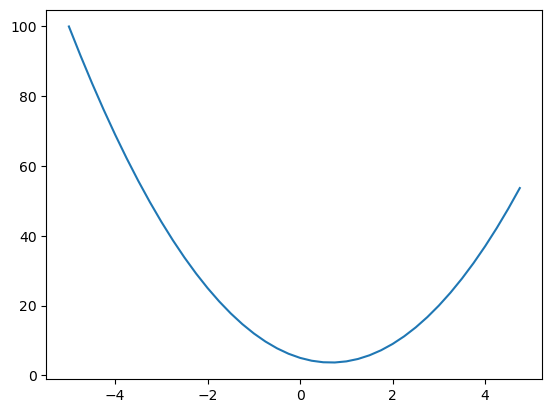

In [4]:
xs=np.arange(-5,5,0.25)
ys=f(xs)
plt.plot(xs,ys)
plt.show()

In [5]:
h=0.000000001
x=2/3
(f(x+h)-f(x))/h

0.0

In [6]:
# let do more complex derivative
a=2.0
b=-3.0
c=10.0
d1=a*b+c
print(f'd={d1}')

d=4.0


In [7]:
h=0.0001
a=2.0
b=-3.0
c=10.0
d1=a*b+c
a+=h
d2=a*b+c
print(f'd={d1}')
print(f'd2={d2}')
print(f'slope={(d2-d1)/h}')

d=4.0
d2=3.999699999999999
slope=-3.000000000010772


In [8]:
# Neural Networks

In [9]:
# Core Value object with visualization

In [131]:

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [132]:
a=Value(10)
b=Value(2)
a/b

Value(data=5.0, grad=0)

In [130]:
# Addition
a=Value(2.0,'a')
b=Value(3.0,'b')
c=a+b;c.label='c'
print(f'c= {c.data} _op ={c._op}, Label={c.label},  Children ={c._prev}')

c= 5.0 _op =+, Label=c,  Children ={Value(data=2.0), Value(data=3.0)}


In [12]:
# Multiplicaion
a=Value(2.0,'a')
b=Value(3.0,'b')
c=a*b; c.label='c';
print(f' c.data = {c.data} Label={c.label} ,  operation={c._op}, children={c._prev}')

 c.data = 6.0 Label=c ,  operation=*, children={Value(data=3.0), Value(data=2.0)}


In [13]:
a= Value(2.0,label='a')
b=Value(-3.0,label='b')
c=Value(10.0,label='c')
e=a*b; e.label='e';
d=e+c; d.label='d';
f=Value(-2.0,label='f')
L=d*f;L.label='L'


In [14]:
# Visulaize the graph


In [15]:
from graphviz import Digraph
# from IPython.display import display
# import python-graphviz

def trace(root):
    # build a set of all nodes and edges in a graph
    nodes,edges=set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot= Digraph(format='svg',graph_attr={'rankdir':'LR'}) #LR -> left to Right
    nodes,edges= trace(root)

    for n in nodes:
        uid = str(id(n))
        # (for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label= "{ %s | data %.4f | grad %.4f }" % (n.label,n.data,n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create a op node for it
            dot.node(name= uid+n._op, label=n._op)
            # And connect the node to the edge
            dot.edge(uid+n._op,uid)

    for n1,n2 in edges:
        # connect the n1 to op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)

    return dot
            

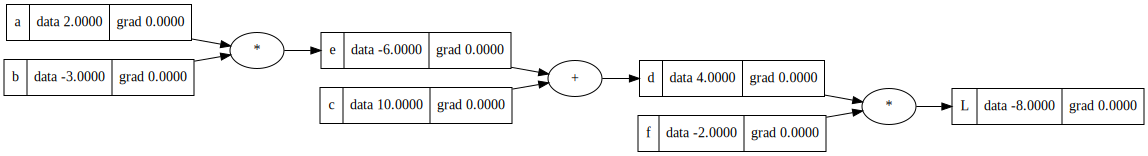

In [16]:
draw_dot(L)

In [17]:
a.data+= 0.01 * a.grad
b.data+= 0.01 * b.grad
c.data+= 0.01 * c.grad
f.data+= 0.01 * d.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-8.0


In [18]:
L.grad=1.0
d.grad=-2.0
f.grad=4.0
c.grad=-2.0
e.grad=-2.0
a.grad=6.0
b.grad=-4.0

In [19]:
def lol():
    h=0.001
    a= Value(2.0,label='a')
    b=Value(-3.0,label='b')
    c=Value(10.0,label='c')
    e=a*b; e.label='e';
    d=e+c; d.label='d';
    f=Value(-2.0,label='f')
    L=d*f;L.label='L'
    L1=L.data

    a= Value(2.0,label='a')
    b=Value(-3.0,label='b')
    b.data+=h
    c=Value(10.0,label='c')
    e=a*b; e.label='e';
    d=e+c; d.label='d';
    f=Value(-2.0,label='f')
    L=d*f;L.label='L'
    L2=L.data

    print((L2-L1)/h)

lol()        

-3.9999999999995595


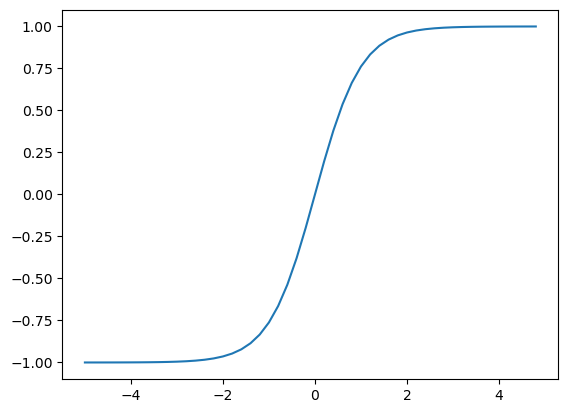

In [20]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)))
plt.show()

In [57]:
# inputs 
X1= Value(2.0, label="x1")
X2= Value(0.0, label="X2")

# Weights W1,W2
W1=Value(-3.0,label="W1")
W2=Value(1.0,label="W2")

# Bias 
b=Value(6.8813735870195432,label="b")

# X1W1 + X2W2 +b
X1W1=X1*W1; X1W1.label="X1*W1"
X2W2=X2*W2; X2W2.label="X2*W2"

X1W1X2W2 = X1W1 + X2W2; X1W1X2W2.label="X1W1+X2W2"
n=X1W1X2W2+b; n.label="n"
o=n.tanh();  o.label="o"

# draw_dot(o)


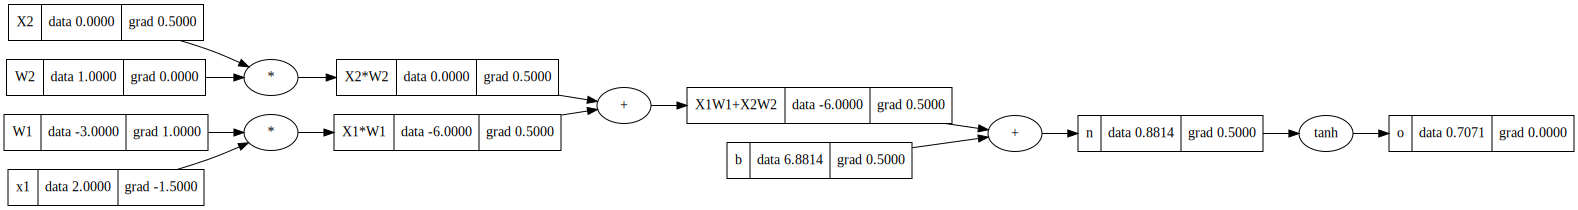

In [60]:
draw_dot(o)

In [59]:
o.backward()

In [38]:
X2._backward()
W2._backward()

In [37]:
X1._backward()
W1._backward()

In [36]:
X1W1._backward()
X2W2._backward()

In [35]:
b._backward()
X1W1X2W2._backward()

In [34]:
n._backward()

In [33]:
o.grad=1.0

In [29]:
X1.grad=-1.5
W1.grad=1.0

In [119]:
X2.grad=0.5
W2.grad=0.0

In [112]:
X1W1.grad=0.5
X2W2.grad=0.5

In [109]:
b.grad=0.5
X1W1X2W2.grad=0.5

In [107]:
n.grad=0.5

In [104]:
o.grad=1.0

In [105]:
1 - o.data**2

0.4999999999999999

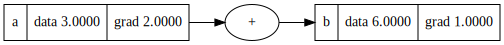

In [233]:
# problem with backprop
a=Value(3.0,label="a")
b= a + a; b.label="b"
b.grad=1.0
a._backward()
draw_dot(b)

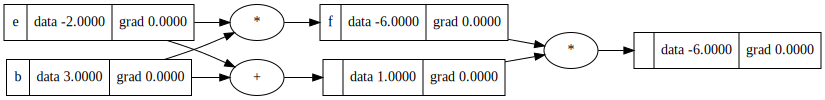

In [236]:
# Problem with backprop
a=Value(-2.0,label="a")
b=Value(3.0,label="b")
d=a*b; d.label="d"
e = a+b; a.label="e"
f=d*e; d.label="f"

draw_dot(f)